## Algorithm animation

Only an idea.

In [1]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as ptc
import matplotlib.colors as mc
import math
from scipy import stats
%matplotlib inline

from matplotlib import animation, rc
from IPython.display import HTML
#from JSAnimation.IPython_display import display_animation

source_file = '/data/Run000262/data_000000.txt'

In [2]:
# loading the dataset
data = pd.read_csv(source_file, sep=",")

def preprocess_dataset(data):
    ### dataframe preprocessing

    # detector, layer, tile
    data['detector'] = pd.Series( (data["TDC_CHANNEL"]/64).apply(np.ceil) + data["FPGA"]*2 , dtype='int')
    data['layer'] = pd.Series( data.TDC_CHANNEL%4, dtype='int')
    data['layer'].replace( {0:1, 2:2, 3:3, 1:4}, inplace=True)
    data['tile']  = pd.Series( ( ((data.TDC_CHANNEL-1)%64)/4 ).apply(np.floor) , dtype='int')
    
    # time [ns]
    t0 = data.ORBIT_CNT.min() # NOTE: because ORBIT_CNT is huge, I shift the time values by the minimum ORBIT_CNT
    data['t'] = pd.Series( (data.ORBIT_CNT-t0)*3564*25 + data.BX_COUNTER*25 + data.TDC_MEAS*25/30)

    # manage trigger hits
    data = data.rename(columns={"HEAD": "trigger"})  # since HEAD is useless, I use it as a trigger marker
    data.loc[data.TDC_CHANNEL > 128, ['detector','layer','tile']] = 0  # because these values do not make sense for triggers
    data.loc[data.TDC_CHANNEL <= 128, 'trigger'] = 0
    
    return data


data = preprocess_dataset(data)
print(f'I loaded a dataset of {len(data)} hits')

# misc
data.head(10)

I loaded a dataset of 1310592 hits


,trigger,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,detector,layer,tile,t
0,0,1,19,1965859059,2882,5,3,3,4,7.205417e+04
1,0,1,37,1965859067,931,1,3,4,9,7.360758e+05
2,0,0,25,1965859082,1906,19,1,4,6,2.096966e+06
3,0,0,25,1965859082,1916,17,1,4,6,2.097214e+06
4,0,1,82,1965859090,3415,5,4,2,4,2.847479e+06
5,0,0,75,1965859093,1227,17,2,3,2,3.060089e+06
6,0,0,63,1965859094,875,24,1,3,15,3.140395e+06
7,0,0,10,1965859101,1100,2,1,2,2,3.769702e+06
8,0,0,47,1965859117,668,3,1,3,11,5.184502e+06
9,0,1,74,1965859120,2465,10,4,2,2,5.496733e+06


### Animation: algorithm III

In [13]:
## animation tools

tiles = []
wrs = []
tx = []
algo_log = []
    
def algo_animation_init(title = None, note = None, focus_area = False,
              legend_primer = '"[{:03d}] {:.2f}ns ({:+.2f})".format(hit_id,time,time-first_time)', 
              legend_x_shift = 0, no_axis = 'default', show_plt = True,
              tile_edgecolor = 'dimgray', tile_linewidth = 0.7, tile_alpha = 1, override_tile_colors = None,
              wire_enable = False, wire_size = 1, wire_alpha = 1, wire_color = 'k' ):
    # This function plots the detector tiles pattern.
    #  output:     tiles     a matrix to control the properties of the tiles
    #  output:     wires     an array with the positions of the wire markers, listed by layer (1 to 4)
    
    fig = plt.figure(figsize=(10, 2), dpi=120)
    ax  = fig.add_subplot(111)
    
    # detector pattern
    dx, dy =  42, 13           # tile shape
    n_layers, n_tiles = 4, 16  # number of layers, and number of tiles per layer
    
    # hit color list
    color_list = ['tomato', 'orange', 'gold', 'springgreen', 'turquoise',
                      'dodgerblue', 'navy', 'mediumpurple','violet', 'hotpink',
                      'lightcoral','peru','olivedrab','indigo','magenta']
        
    wires = []
    tiles = []
    for jj in range(n_layers):
        row = [];
        for ii in range(n_tiles):
            t = ptc.Rectangle( (ii*dx-dx*(jj%2)/2,jj*dy), dx, dy, 
                              edgecolor=tile_edgecolor,facecolor='none',linewidth=tile_linewidth)
            ax.add_patch( t )
            row.append(t)
            wires.append( (ii*dx-dx*(jj%2)/2 + dx/2, jj*dy + dy/2) )
            #ax.text(ii*dx+dx*(jj%2)/2, jj*dy, f'{ii+1}')
        tiles.append(row)
    del row
    
    plt.xlim(-3*dx/2, dx*n_tiles + dx);    plt.ylim(-dy, dy*(n_layers+1));
    plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout();    ax.yaxis.set_visible(False);    #ax.xaxis.set_visible(False);
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    
    if title: plt.title(title)
    if no_axis == 'default':
        if focus_area: no_axis = True
        else: no_axis = False
    if no_axis: ax.axis('off')
    if focus_area: tiles_range = []
        
    if focus_area:  # if true, plots only the appropriate range of tiles
        plt.xlim( -3 + dx*(min(tiles_range)-1), 3 + dx*max(tiles_range) + 3*dx/2)
        plt.ylim( -dy, dy*n_layers + 5)
        if note: ax.text(3 + dx*(max(tiles_range)-2.5) + 3*dx/2, -dy/2 , note, size=8)
    else:
        if note: ax.text(0, -17, note, size=8)

    if wire_enable: plt.scatter(*zip(*wires), c=wire_color, s=wire_size, alpha=wire_alpha, zorder=2)
    return fig, tiles, wires

enhanced_algorithm = False
def animate_progression(t):
    global enhanced_algorithm
    i = t*2 +1
    
    # select the mask margins:
    lma, rma = i, i+3   # active mask
    lms, rms = max(1, i-4), min(64, i+7)  # sensitivity mask

    
    # reset all the color tiles
    for tr in tiles:
        for tc in tr: tc.set( edgecolor='dimgrey', facecolor='w', linewidth=0.7 ) 
    
    if enhanced_algorithm:
        for j in range(lms,lma):
            tile_from_tdc(tiles,j).set( edgecolor='orangered', linewidth=1.4 )
        for j in range(rma+1,rms+1):
            tile_from_tdc(tiles,j).set( edgecolor='orangered', linewidth=1.4 ) 
        for j in range(lma,rma+1):
            tile_from_tdc(tiles,j).set( edgecolor='dodgerblue', linewidth=2.5 )
    else:
        for j in range(lma,rma+1): 
            tile_from_tdc(tiles,j).set( edgecolor='orange', linewidth=2.5 )
    return []

def tdc_to_lcid(tdc):  # tdc_channel to layer-cell numeration
    layer = tdc%4;    repl = {0:1, 2:2, 3:3, 1:4};
    return [repl[layer], int( np.floor(((tdc-1)%64)/4) ) ]

def tile_from_tdc(tls,tdc):  # tdc_channel to tile object
    layer = tdc%4;    repl = {0:1, 2:2, 3:3, 1:4};
    return tls[ repl[layer] -1][ int( np.floor(((tdc-1)%64)/4) ) ]

def enable_wire( x, c = 'k', s=27):
    layer = x[0];  tile = x[1];
    wire_coord = wrs[ (layer-1)*16 + tile ]
    mark_coord = ( wire_coord[0] - 0, wire_coord[1] )
    return plt.scatter( (*mark_coord), zorder=2, c=c, marker='x', s=s)

def init_animation( hit_list = [ 14, 15, 16], title = 'Algorithm (II): cell progression with sample hits [ex1]' ):
    global tiles, wrs, tx, algo_log
    fig, tiles, wrs = algo_animation_init()
    plt.title(title)
    tx = plt.text( 530, -57 , '', fontname= 'monospace', size=8)
    for hit in hit_list:  enable_wire( tdc_to_lcid(hit) )
    algo_log=''
    return fig, hit_list

# animation function:  algoritm 1
def animate_cell_1_hits(t):
    global tiles, wrs, tx, algo_log  
    i = t*2 +1
    
    # select the mask margins:
    lma, rma = i, i+3   # active mask
    
    # reset all the color tiles
    for tr in tiles:
        for tc in tr: tc.set( edgecolor='dimgrey', facecolor='w', linewidth=0.7 ) 
    
    for j in range(lma,rma+1): tile_from_tdc(tiles,j).set( edgecolor='orange', linewidth=2.5 )
    
    # counting events in mask
    count = 0
    indic = []
    for hit in hit_list:
        if hit in range(lma,rma+1):
            tile_from_tdc(tiles,hit).set( facecolor='khaki' )
            indic.append(hit)
            count += 1

    if count == 0:  xtext= f'step {t}  ->  {count} hits in mask (continue)'
    elif count < 3: xtext= f'step {t}  ->  {count} hits in mask (reject)'
    elif count < 5:
        xtext= f'step {t}  ->  {count} hits in mask (keep it as an event)'
        algo_log += f'event found in [{indic}]\n'
    else:           xtext= f'step {t}  ->  {count} hits in mask (reject)'
    
    plt.xlabel(xtext, horizontalalignment='left', x= 0.05)
    tx.set(text = algo_log)
    return []

# animation function:  algoritm II
def animate_cell_2_hits(t):
    global algo_log
    
    if t == 17:   plt.xlabel(f'step {t}  ->  2 hits in mask (reject)')
    elif t == 18: plt.xlabel(f'step {t}  ->  3 hits in mask (keep it)')
    elif t == 19: plt.xlabel(f'step {t}  ->  3 hits in mask (keep it)')
    else: plt.xlabel(f'step {t}  ->  no events in mask')
    
    i = t*2 +1
    
    # select the mask margins:
    lma, rma = i, i+3   # active mask
    lms, rms = max(1, i-4), min(64, i+7)  # sensitivity mask
    
    # reset all the color tiles
    for tr in tiles:
        for tc in tr: tc.set( edgecolor='dimgrey', facecolor='w', linewidth=0.7 ) 
    
    for j in range(lms,lma):
        tile_from_tdc(tiles,j).set( edgecolor='orangered', linewidth=1.4 )
    for j in range(rma+1,rms+1):
        tile_from_tdc(tiles,j).set( edgecolor='orangered', linewidth=1.4 ) 
    for j in range(lma,rma+1):
        tile_from_tdc(tiles,j).set( edgecolor='dodgerblue', linewidth=2.5 )
    
    # counting events in mask
    count = 0;   indic = [];  reject = False;
    for hit in hit_list:
        if hit in range(lma,rma+1):
            tile_from_tdc(tiles,hit).set( facecolor='lightskyblue' )
            indic.append(hit)
            count += 1
        elif hit in range(lms,rms+1):
            tile_from_tdc(tiles,hit).set( facecolor='lightsalmon' )
            #indic.append(hit)
            reject = True
        
    
    if count == 0:   xtext= f'step {t}  ->  {count} hits in mask (continue)'
    elif count < 3:  xtext= f'step {t}  ->  {count} hits in mask (reject)'
    elif count < 5:
        if reject:
            xtext= f'step {t}  ->  {count} hits in mask, but the event is not clear (reject)'
            algo_log += f'  rejecting [{indic}]\n'
        else:
            xtext= f'step {t}  ->  {count} hits in mask (accept as event)'
            algo_log += f'event found in [{indic}]\n'
    else:            xtext= f'step {t}  ->  {count} hits in mask (reject)'
    
    plt.xlabel(xtext, horizontalalignment='left', x= 0.05)
    tx.set(text = algo_log)
    return []

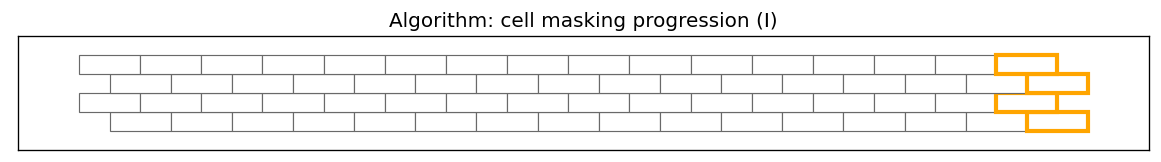

In [4]:
## ANIMATION:    Algo I mask progression
enhanced_algorithm = False
fig, tiles, wrs , = algo_animation_init()
plt.title('Algorithm: cell masking progression (I)')
anim = animation.FuncAnimation(fig, animate_progression,  frames=31, interval=400, blit=True)
display(HTML(anim.to_jshtml()))

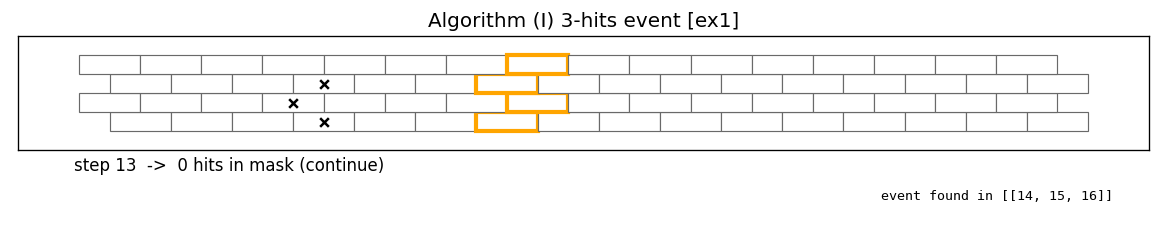

In [5]:
## ANIMATION:    Algo I + sample hits (3 hit event)
fig, hit_list = init_animation( hit_list = [ 14, 15, 16], title = 'Algorithm (I) 3-hits event [ex1]' )
anim = animation.FuncAnimation(fig, animate_cell_1_hits, frames=14, interval=700, blit=True)
display(HTML(anim.to_jshtml()))

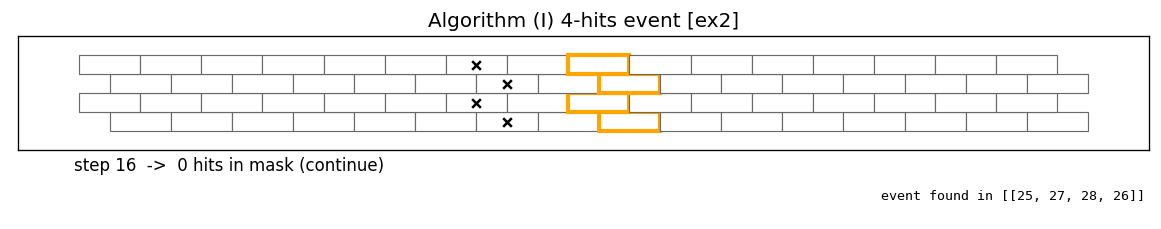

In [6]:
## ANIMATION:    Algo I + sample hits (4 hit event)
fig, hit_list = init_animation( hit_list = [25, 27, 28, 26], title = 'Algorithm (I) 4-hits event [ex2]' )
anim = animation.FuncAnimation(fig, animate_cell_1_hits, frames=17, interval=500, blit=True)
display(HTML(anim.to_jshtml()))

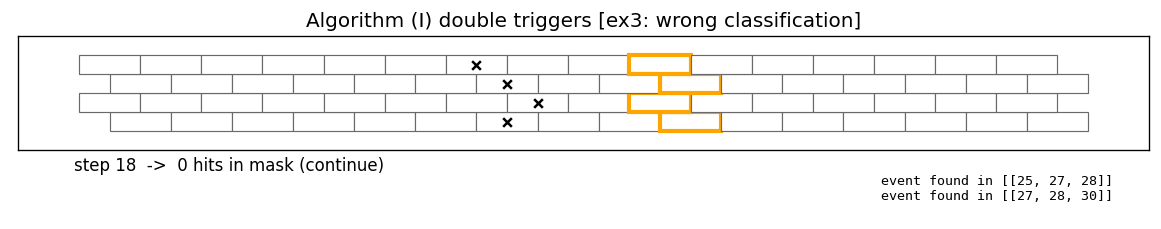

In [7]:
## ANIMATION:    Algo I + sample hits (error case)
fig, hit_list = init_animation( hit_list = [25,27,28,30], title = 'Algorithm (I) double triggers [ex3: wrong classification]' )
anim = animation.FuncAnimation(fig, animate_cell_1_hits, frames=19, interval=500, blit=True)
display(HTML(anim.to_jshtml()))

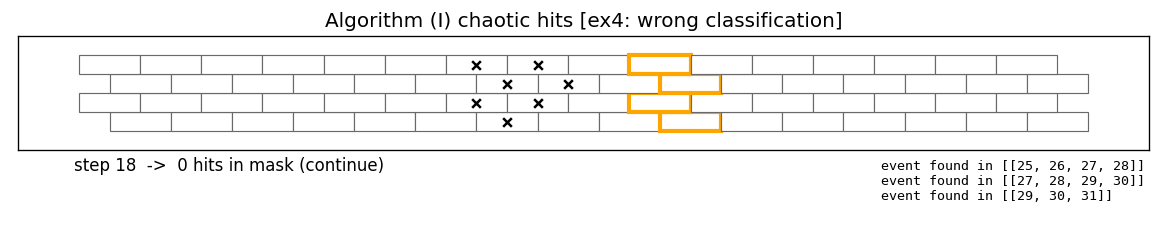

In [8]:
## ANIMATION:    Algo II + sample hits (error case)
fig, hit_list = init_animation( hit_list =  [25,26,27,28,29,30,31], title = 'Algorithm (I) chaotic hits [ex4: wrong classification]' )
anim = animation.FuncAnimation(fig, animate_cell_1_hits, frames=19, interval=500, blit=True)
display(HTML(anim.to_jshtml()))

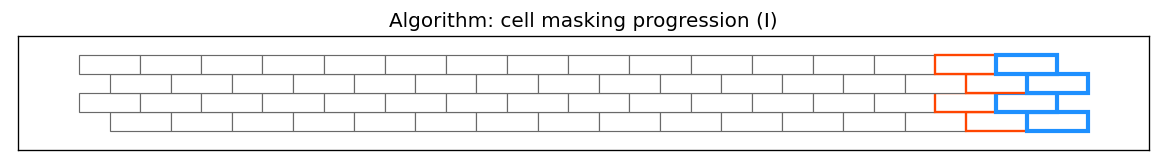

In [9]:
## ANIMATION:    Algo II masking
enhanced_algorithm = True
fig, tiles, wrs , = algo_animation_init()
plt.title('Algorithm (II): cell masking progression')
anim = animation.FuncAnimation(fig, animate_progression,  frames=31, interval=400, blit=True)
display(HTML(anim.to_jshtml()))

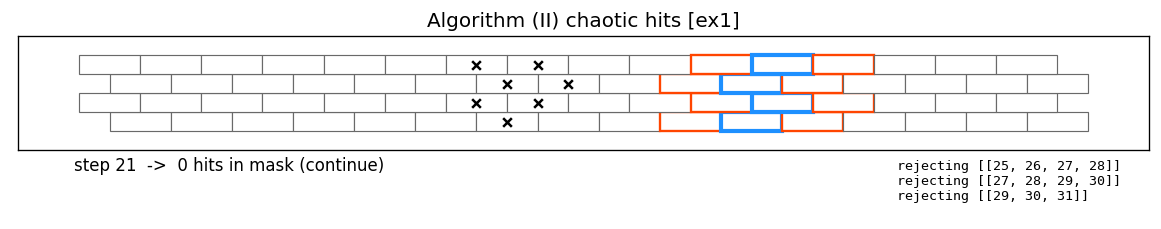

In [14]:
## ANIMATION:    Algo II + sample hits (solving error)
fig, hit_list = init_animation( hit_list = [25,26,27,28,29,30,31], title = 'Algorithm (II) chaotic hits [ex1]' )
anim = animation.FuncAnimation(fig, animate_cell_2_hits, frames=22, interval=500, blit=True)
display(HTML(anim.to_jshtml()))

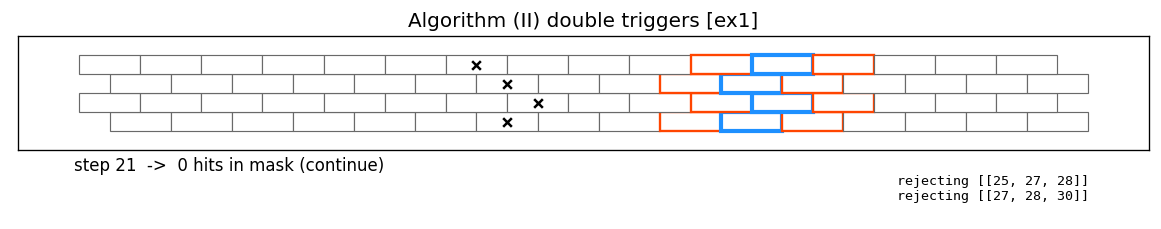

In [15]:
## ANIMATION:    Algo II + sample hits (undesired pattern)
fig, hit_list = init_animation( hit_list=[25,27,28,30], title = 'Algorithm (II) double triggers [ex2]' )
anim = animation.FuncAnimation(fig, animate_cell_2_hits, frames=22, interval=500, blit=True)
display(HTML(anim.to_jshtml()))

http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/

### DRAFT

End of file.